In [87]:
# I didn't put any google trends data here since we are only exploring amazon reviews in this notebook.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
    
    
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline


def GetMergedAmazonDataFrames():
#     files_to_use = [r'data\AirPods Pro.csv', r'data\Elite 75t.csv',r'data\Free.csv',
#                    r'data\Galaxy Buds Plus.csv',r'data\M-200.csv',r'data\NC700.csv',
#                    r'data\Soundcore Liberty 2 Pro.csv',r'data\Soundcore Liberty Air 2.csv',r'data\Soundcore Life Q20.csv',
#                    r'data\WF-1000XM3.csv']
    files_to_use = [r'data\AirPods Pro.csv', r'data\Elite 75t.csv',r'data\Free.csv',
                   r'data\Galaxy Buds Plus.csv',r'data\NC700.csv',
                   r'data\Soundcore Liberty 2 Pro.csv',r'data\Soundcore Liberty Air 2.csv',r'data\Soundcore Life Q20.csv',
                   r'data\WF-1000XM3.csv']
    
    amzn_df = pd.read_csv(files_to_use[0],  parse_dates=False)
    for file in files_to_use[1:]:
        df = pd.read_csv(file,  parse_dates=False)
#         amzn_df = pd.merge(amzn_df, df, how='outer',on='review_date')
        amzn_df = pd.concat([amzn_df,df],sort=False)
        
    amzn_df['review_date'] = pd.to_datetime(amzn_df['review_date'], format='%Y-%m-%d')
    amzn_df = amzn_df[['Manufacturer', 'ProductName', 'review_rating', 'verified_purchase',
       'review_date', 'review_title', 'review_text']]
    return amzn_df
    

import numpy as np

def GetAmazonTextReviewsDf():
    ### This function is used to prepare 
    #   the data frame to word and text analysis.. ####
    amzn_df = GetMergedAmazonDataFrames()
    columns = ['Manufacturer', 'ProductName', 'review_rating', 'verified_purchase',
       'review_date', 'review_title', 'review_text']
    
    amzn_df=amzn_df[columns]
    return amzn_df
#     amzn_df['totalReviews'] =
    
def GetAmazonNumericalReviewsDf():
    amzn_df = GetMergedAmazonDataFrames()
    columns = ['Manufacturer', 'ProductName', 'review_rating', 'verified_purchase',
       'review_date']
    
    amzn_df=amzn_df[columns]
    # split into two data sets for purchased and not purchased.
    amzn_purchased = amzn_df.where(amzn_df['verified_purchase']== 1).dropna()
    amzn_notPurchased = amzn_df.where(amzn_df['verified_purchase']== 0).dropna()
    
    tempdf = None
    for product in amzn_purchased['ProductName'].unique():
        df = amzn_purchased.where(amzn_purchased['ProductName'] == product).dropna()
        
        manufacturer = df['Manufacturer'].unique()[0]
        df= df[['review_rating','review_date']]
        
        dfCount = df
        df = df.set_index('review_date').resample('W-SAT').mean().reset_index()#.agg(['mean','count']).reset_index()
#         df['review_rating'] = df['review_rating'].fillna(0)
        df['review_rating_norm'] = Normalize(df['review_rating'].fillna(df['review_rating'].mean()))
        df['ProductName'] = df['review_rating'].apply(lambda x: product)
        df['Manufacturer'] = df['review_rating'].apply(lambda x: manufacturer)
        df['verified_purchase'] = df['review_rating'].apply(lambda x: '1')
        df['count'] = dfCount[['review_rating','review_date']].set_index('review_date').resample('W-SAT').count().reset_index()['review_rating']
#         print(df.head())
        if tempdf is None:
            tempdf = df
        else:
            tempdf = pd.concat([tempdf, df])
            
    
    for product in amzn_notPurchased['ProductName'].unique():
        df = amzn_notPurchased.where(amzn_notPurchased['ProductName'] == product).dropna()
        
        manufacturer = df['Manufacturer'].unique()[0]
        df= df[['review_rating','review_date']]
        
        dfCount = df
        
        
        df = df.set_index('review_date').resample('W-SAT').mean().reset_index()#.agg(['mean','count']).reset_index()
#         df['review_rating'] = df['review_rating'].fillna(0)
        df['review_rating_norm'] = Normalize(df['review_rating'].fillna(df['review_rating'].mean()))
        df['ProductName'] = df['review_rating'].apply(lambda x: product)
        df['Manufacturer'] = df['review_rating'].apply(lambda x: manufacturer)
        df['verified_purchase'] = df['review_rating'].apply(lambda x: '0')
        df['count'] = dfCount[['review_rating','review_date']].set_index('review_date').resample('W-SAT').count().reset_index()['review_rating']
        
#         print(df.head())
        if tempdf is None:
            tempdf = df
        else:
            tempdf = pd.concat([tempdf, df])
            
    return tempdf
    

In [88]:
# Math functions

In [89]:
def Normalize(array):
    return array / np.linalg.norm(array, ord=1)
    
# Sav-golay filter for averaging.
def savGolay(array, window = 9, order =7):
    from scipy.ndimage import convolve1d
    from scipy.signal import savgol_coeffs, savgol_filter
    from scipy.signal._savitzky_golay import _polyder
    return savgol_filter(array, window, order)
   
# Simple Moving Average used in financial data.
def SMA(pandas_df_daily,columnName, dayWindowSize=20):
    daily_close_df = pandas_df_daily[columnName].copy()
    return daily_close_df.rolling(dayWindowSize).mean()

# Functions for working with words

In [90]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

def TokenizeText(text):
    from nltk.tokenize import RegexpTokenizer
    tokenizer = RegexpTokenizer(r'\w+')
#     text = "This is my text. It includes commas, question marks? and other stuff. Also U.S..".lower()
    tokens = tokenizer.tokenize(text)
    return tokens

def GetWordsAndTheirTags(text):
    text = CleanText(text)
    tokens = TokenizeText(text)
    return nltk.pos_tag(tokens)

def CleanText(text):
    text=str(text)
    text= text.lower().replace("wouldn\'t","would not").replace('canceling','cancelling')
    return text
def helperGetWordsWithTokenType(text, t):   
# #     print(nltk.help.upenn_tagset('PRP$'))
# #     print(text)
#     text = CleanText(text)
#     tokens = TokenizeText(text)
# #     for duo in nltk.pos_tag(tokens):
# #         if duo[1] =='JJ': # adjectives
# #             print(duo)           
#     return [x[0] for x in nltk.pos_tag(tokens) if x[1]=='JJ']
    tokens = TokenizeText(text)          
    return [x[0] for x in nltk.pos_tag(tokens) if x[1] in t]
    
def GetAdjectivesFromText(text):
    text = CleanText(text)
    return helperGetWordsWithTokenType(text,['JJ'])

def GetNounsFromText(text):
    text = CleanText(text)
    return helperGetWordsWithTokenType(text,['NN','NNS'])

def GetVerbssFromText(text):
    text = CleanText(text)
    # Verbs are tricky... we have to add a 'to' before every word in the text, so we can convert words to verbs
    # this will return any words that can be interpreted as a verb even if not used in the text that way.
    # it's difficult to know by the text alone if a word is a verb or not, so this will force it to a verb.
    
    tokens = TokenizeText(text)   
    
    words = [ 'to '+ x for x in tokens]
#     print(' '.join(words))
    return helperGetWordsWithTokenType(' '.join(words),['VBZ','VB'])

def GetWordPairs(text):
    text = CleanText(text)
    tokens = TokenizeText(text)
    
    
    STOPWORDS = ['of' ,'the', 'i', 'on', 'and', 'm', 'it' ,'s', 've', 'if' ,'to', 'don' ,'t' ,'are' ,'they'\
                 ,'not', 'but','them' ,'do' ,'then' ,'you' ,'me' \
                 ,'these' ,'a' ,'is' ,'for', 'can', 'you' ,'this' ,'my', 'we' ,'can', 'have', 'than', 'with']
    
    
    from nltk.stem import PorterStemmer
#     from nltk.tokenize import sent_tokenize, word_tokenize

    ps = PorterStemmer()

    tokens = [ ps.stem(elem) for elem in tokens if elem not in STOPWORDS]
    
#     tokens= GetAdjectivesFromText(text)
    #we need to create a new array with pairs of the words in the tokens array.
    if len(tokens)< 2:
        return []
    
    pairs = []
    for i in range(0,len(tokens)-1,1):
        firstWord = tokens[i]
        secondWord = tokens[i+1]
        pairs.append(set([firstWord,secondWord]))
    #     print(set([firstWord,secondWord]))
#     print(pairs)
    return pairs

def GetWordTriplets(text):
    text = CleanText(text)
    tokens = TokenizeText(text)
    
    #we need to create a new array with pairs of the words in the tokens array.

    pairs = []
    for i in range(0,len(tokens)-2,1):
        firstWord = tokens[i]
        secondWord = tokens[i+1]
        thirdWord = tokens[i+2]
        pairs.append(set([firstWord,secondWord,thirdWord]))
    #     print(set([firstWord,secondWord]))
#     print(pairs)
    return pairs

from collections import defaultdict
def count_frequency(word_list):
    """ Function input: list object contains strings of individual words.
        Function output: defaultdict() object containing {word, frequency} pairs. """

    freq_counts = defaultdict(int)
    
    for word in word_list:
        freq_counts[word] += 1

    return freq_counts

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\AngryGamers\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\AngryGamers\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [91]:
# GetVerbssFromText("This is my hate text. It includes commas, question marks? dog and other stuff. Also U.S..wouldn't it be great")
# GetAdjectivesFromText("This is my text. It includes commas, question marks? and other stuff. Also U.S..".lower())
# #     print(duo[1])
# # tokens
# GetWordsAndTheirTags("This is my hate text. It includes commas, question marks? dog and other stuff. Also U.S..wouldn't it be great")

# text = CleanText("This is my hate text. It includes commas, question marks? dog and other stuff. Also U.S..wouldn't it be great")
# tokens = TokenizeText(text)  

# pairs = []
# for i in range(0,len(tokens)-1,1):
#     firstWord = tokens[i]
#     secondWord = tokens[i+1]
#     pairs.append(set([firstWord,secondWord]))
# #     print(set([firstWord,secondWord]))
# print(pairs)
# # tokens.rotate(1)
# GetWordPairs("This is my hate text. It includes commas, question marks? dog and other stuff. Also U.S..wouldn't it be great")

In [92]:
# Functions to tweak pandas data frames.
def AddAdjectiveNounsVerbsToDF(df, textColumn):
    df = df.copy()
#     amzn_df['text_adjectives'] =amzn_df['review_text'].apply(lambda x: GetAdjectivesFromText(str(x).lower()))
#     amzn_df['text_nouns'] =amzn_df['review_text'].apply(lambda x: GetNounsFromText(str(x).lower()))
#     amzn_df['text_verbs'] =amzn_df['review_text'].apply(lambda x: GetVerbssFromText(str(x).lower()))
    df['text_adjectives'] =df[textColumn].apply(lambda x: GetAdjectivesFromText(str(x).lower()))
    df['text_adjectives'] = df['text_adjectives'].apply(lambda row: set([  x for x in row if(len(x) >1)]) )
    
    df['text_nouns'] =df[textColumn].apply(lambda x: GetNounsFromText(str(x).lower()))
    df['text_nouns'] = df['text_nouns'].apply(lambda row: set([  x for x in row if(len(x) >1)]) )
    
    df['text_verbs'] =df[textColumn].apply(lambda x: GetVerbssFromText(str(x).lower()))
    df['text_verbs'] = df['text_verbs'].apply(lambda row: set([  x for x in row if(len(x) >1)]) )
    
    # create word pairs.
    df['text_pairs'] = df[textColumn].apply(lambda row: GetWordPairs(row))
    df['text_triplets'] = df[textColumn].apply(lambda row: GetWordTriplets(row))
    return df

def GetDataframeOfWords(pandasdf, textColumn):
#     pandasdf['words'] = CreateListForColumn(pandasdf, textColumn)
    pandasdf['words']=pandasdf[textColumn]
    wordArray = pandasdf[pandasdf['words'].map(lambda d: len(d)) > 0]['words'].values
    words = []
    for wordlist in wordArray:
        words.extend(wordlist)
    wordDictionary = count_frequency(words)
    
    df = pd.DataFrame.from_dict(wordDictionary, orient='index',
                       columns=['count']).reset_index()
    df = df.rename(columns={"index": "word"})
    df = df.sort_values(by=['count'], ascending=False)
    
    totalWords = df['count'].sum()
    df['usage'] = df['count']/totalWords
#     df = df.set_index('word')
    
    return df

In [93]:
amzn_df = GetAmazonTextReviewsDf()
amzn_df = AddAdjectiveNounsVerbsToDF(amzn_df,'review_text')
amzn_df.head()

,Manufacturer,ProductName,review_rating,verified_purchase,review_date,review_title,review_text,text_adjectives,text_nouns,text_verbs,text_pairs,text_triplets
0,Apple,AirPods Pro,5,0,2019-10-30,Airpods Pro deliver😎,This airpods pro do exactly what apple said th...,"{many, different, new}","{airpods, buds, size, put, thats, alot, noise,...","{noise, transperancy, resistant, do, tell, com...","[{pro, airpod}, {pro, exactli}, {what, exactli...","[{airpods, pro, this}, {airpods, pro, do}, {pr..."
1,Apple,AirPods Pro,4,0,2019-10-30,List of Features/Changes compared to Airpods (v2),"Like iphone 11 Pro, Macbook Pro, Airpad Pro; t...","{black, replacement, old, noise, non, likely, ...","{iphone, range, mode, ease, users, non, noise,...","{iphone, play, feel, range, mode, macbook, eas...","[{iphon, like}, {iphon, 11}, {pro, 11}, {pro, ...","[{iphone, 11, like}, {pro, iphone, 11}, {pro, ..."
2,Apple,AirPods Pro,3,0,2019-10-30,Cool but expensive,First review yeh heard about these excited but...,{excited},"{airpods, review, dollars}","{less, first, yeh, heard, review, like, get}","[{review, first}, {review, yeh}, {heard, yeh},...","[{yeh, review, first}, {heard, review, yeh}, {..."
3,Apple,AirPods Pro,5,0,2019-10-30,Lit,They fire,{},{},{fire},[],[]
4,Apple,AirPods Pro,5,1,2019-10-31,Saved my marriage,"With the new transparency mode, I can listen t...",{new},"{street, music, mode, cook, car, boys, transpa...","{street, listen, be, mode, cook, ran, boys, tr...","[{new, transpar}, {transpar, mode}, {listen, m...","[{with, the, new}, {transparency, new, the}, {..."


In [94]:
amzn_df.head()

,Manufacturer,ProductName,review_rating,verified_purchase,review_date,review_title,review_text,text_adjectives,text_nouns,text_verbs,text_pairs,text_triplets
0,Apple,AirPods Pro,5,0,2019-10-30,Airpods Pro deliver😎,This airpods pro do exactly what apple said th...,"{many, different, new}","{airpods, buds, size, put, thats, alot, noise,...","{noise, transperancy, resistant, do, tell, com...","[{pro, airpod}, {pro, exactli}, {what, exactli...","[{airpods, pro, this}, {airpods, pro, do}, {pr..."
1,Apple,AirPods Pro,4,0,2019-10-30,List of Features/Changes compared to Airpods (v2),"Like iphone 11 Pro, Macbook Pro, Airpad Pro; t...","{black, replacement, old, noise, non, likely, ...","{iphone, range, mode, ease, users, non, noise,...","{iphone, play, feel, range, mode, macbook, eas...","[{iphon, like}, {iphon, 11}, {pro, 11}, {pro, ...","[{iphone, 11, like}, {pro, iphone, 11}, {pro, ..."
2,Apple,AirPods Pro,3,0,2019-10-30,Cool but expensive,First review yeh heard about these excited but...,{excited},"{airpods, review, dollars}","{less, first, yeh, heard, review, like, get}","[{review, first}, {review, yeh}, {heard, yeh},...","[{yeh, review, first}, {heard, review, yeh}, {..."
3,Apple,AirPods Pro,5,0,2019-10-30,Lit,They fire,{},{},{fire},[],[]
4,Apple,AirPods Pro,5,1,2019-10-31,Saved my marriage,"With the new transparency mode, I can listen t...",{new},"{street, music, mode, cook, car, boys, transpa...","{street, listen, be, mode, cook, ran, boys, tr...","[{new, transpar}, {transpar, mode}, {listen, m...","[{with, the, new}, {transparency, new, the}, {..."


In [95]:
# https://www.mikulskibartosz.name/how-to-split-a-list-inside-a-dataframe-cell-into-rows-in-pandas/

# GetDataframeOfWords(amzn_df,'text_adjectives')
# GetDataframeOfWords(amzn_df,'text_verbs')


# GetDataframeOfWords(amzn_df[:50],'text_pairs')
# from collections import Counter
# Counter(amzn_df[:50]['text_pairs'])

# amzn_df[:50]['text_pairs'].value_counts()

# data = amzn_df[40:50][['review_date','verified_purchase','text_pairs']]
# data = amzn_df[40:50]

# data['text_pairs']#.apply(lambda x: x[0])

# data=data.reset_index()
# # data.where(data['text_pairs'])

# ### This is a bit tricky what this is doing...###
# #  we create a new temp column, which is where we get the values from that we'll be working with.
# #  take the column and dumping that into it's own data frame, which makes a bunch of columns. (from array to df)
# #  merge the the new dataframe with all of our many columns back into the original data frame with columns we want to keep.
# #  we remove the temp column. This temp column would melt into our final column we are making...
# #     the issue I had was without removing the column I could get pairs merged with other pairs, wo they ended up being 
# #     sets of 3+ merged with who knows what, which isn't what I wanted.
# #  there is a variable column that's created in this process which we can remove.
# data["tempPairs"] = data["text_pairs"]
# data = data['text_pairs'].apply(pd.Series)\
#     .merge(data, right_index = True, left_index = True) \
#     .drop(["tempPairs"], axis = 1)\
#     .drop(["text_pairs"], axis = 1)\
#     .melt(id_vars = ['review_date', 'verified_purchase'], value_name = "pairs") \
#     .drop("variable", axis = 1)

# data = amzn_df[['review_date','verified_purchase','text_pairs']]
# data = GetReviewPairsCounts(data, 'text_pairs',['review_date', 'verified_purchase'] )

# Single Words

This section will cover analysis of only single words found in the list. We will take a top down approach.<br><br>
<ul>
    <li> high reviews are above 3 and low reviews are less than 3, what are the unique words between the high and low?</li>
    <li> what are the unique words between the purchased and not purchased?</li>
    <li> what are the unique words between the products?</li>



</ul>

In [96]:
print(amzn_df.columns)
amzn_df.head()

Index(['Manufacturer', 'ProductName', 'review_rating', 'verified_purchase',
       'review_date', 'review_title', 'review_text', 'text_adjectives',
       'text_nouns', 'text_verbs', 'text_pairs', 'text_triplets'],
      dtype='object')


,Manufacturer,ProductName,review_rating,verified_purchase,review_date,review_title,review_text,text_adjectives,text_nouns,text_verbs,text_pairs,text_triplets
0,Apple,AirPods Pro,5,0,2019-10-30,Airpods Pro deliver😎,This airpods pro do exactly what apple said th...,"{many, different, new}","{airpods, buds, size, put, thats, alot, noise,...","{noise, transperancy, resistant, do, tell, com...","[{pro, airpod}, {pro, exactli}, {what, exactli...","[{airpods, pro, this}, {airpods, pro, do}, {pr..."
1,Apple,AirPods Pro,4,0,2019-10-30,List of Features/Changes compared to Airpods (v2),"Like iphone 11 Pro, Macbook Pro, Airpad Pro; t...","{black, replacement, old, noise, non, likely, ...","{iphone, range, mode, ease, users, non, noise,...","{iphone, play, feel, range, mode, macbook, eas...","[{iphon, like}, {iphon, 11}, {pro, 11}, {pro, ...","[{iphone, 11, like}, {pro, iphone, 11}, {pro, ..."
2,Apple,AirPods Pro,3,0,2019-10-30,Cool but expensive,First review yeh heard about these excited but...,{excited},"{airpods, review, dollars}","{less, first, yeh, heard, review, like, get}","[{review, first}, {review, yeh}, {heard, yeh},...","[{yeh, review, first}, {heard, review, yeh}, {..."
3,Apple,AirPods Pro,5,0,2019-10-30,Lit,They fire,{},{},{fire},[],[]
4,Apple,AirPods Pro,5,1,2019-10-31,Saved my marriage,"With the new transparency mode, I can listen t...",{new},"{street, music, mode, cook, car, boys, transpa...","{street, listen, be, mode, cook, ran, boys, tr...","[{new, transpar}, {transpar, mode}, {listen, m...","[{with, the, new}, {transparency, new, the}, {..."


In [97]:

def SingleWords_df(df):
    data = df.copy()
    data = data[['verified_purchase','review_date', 'text_adjectives']]
    # highAdjectivesRanking['text_adjectives'] = highAdjectivesRanking['text_adjectives'].apply(lambda x: repr(x))
    data["tempPairs"] = data["text_adjectives"]
    data = data['text_adjectives'].apply(lambda x: pd.Series(list(x)))\
        .merge(data, right_index = True, left_index = True) \
        .drop(["tempPairs"], axis = 1)\
        .drop(["text_adjectives"], axis = 1)\
        .melt(id_vars = ['review_date', 'verified_purchase'], value_name = "words") \
        .drop("variable", axis = 1).dropna()
    
    
    # count should be a ratio of the current elem/total sets. NOTE: can't really count them here...value too small.
    totalReview= len(df['verified_purchase'])
    data['count'] = data['verified_purchase'].apply(lambda x: 1/totalReview)
    
    return data


def GetHighAndLowRankingUniqueWords(df, wordColumn):
    lowAdjectivesRanking = df.where(df['review_rating'] < 2).dropna()
    lowAdjectivesRanking = SingleWords_df(lowAdjectivesRanking)

    highAdjectivesRanking = df.where(df['review_rating'] > 4).dropna()
    highAdjectivesRanking = SingleWords_df(highAdjectivesRanking)
    
    adjCount_temp = highAdjectivesRanking[[wordColumn,'count']].groupby([wordColumn]).sum().sort_values(by='count',ascending=False).reset_index()
    adjCount_temp2 = lowAdjectivesRanking[[wordColumn,'count']].groupby([wordColumn]).sum().sort_values(by='count',ascending=False).reset_index()

    intersection = adjCount_temp.merge(adjCount_temp2, left_on=wordColumn, right_on=wordColumn, how='inner')

    # highAdjectivesRanking['words'].isin(intersection['words'].unique())
    top_adj_words_df = highAdjectivesRanking[~highAdjectivesRanking[wordColumn].isin(intersection[wordColumn].unique())].groupby(wordColumn).sum().sort_values(by='count',ascending=False)
    lower_adj_words_df = lowAdjectivesRanking[~lowAdjectivesRanking[wordColumn].isin(intersection[wordColumn].unique())].groupby(wordColumn).sum().sort_values(by='count',ascending=False)

    #NOTE: the intersection or ratings 2-4 don't have any good unique words to use, so by using the extremes we can find more uniqueness.
    # intersection
    df = lower_adj_words_df.reset_index().reset_index()[['index',wordColumn]]#.head()
    top_adj_words_df=top_adj_words_df.reset_index().reset_index()[['index',wordColumn]]#.head()

    # these include purchased and not purchased reviews and all products.
    onevfiveStarReviewWords_df = df.merge(top_adj_words_df, left_on='index', right_on='index', how='inner')
    onevfiveStarReviewWords_df = onevfiveStarReviewWords_df.rename(columns={wordColumn+'_x':'oneStarWords', wordColumn+'_y':'fiveStarWords','index':'rank'})
    return onevfiveStarReviewWords_df
    
# This function will get the words in the highest and lowest star reviews for each product.
def GetProductUniqueWords(df):
    products = df['ProductName'].unique()
    
    temp_df = None
    for elem in products:
        p_df = df.where(df['ProductName'] == elem)
        
        p_df = GetHighAndLowRankingUniqueWords(p_df, 'words')
        # now we have a data set of the top and lowest words for a specific product
        # let's rename oneStarWords to the productNameTop,productNameLowest
        p_df = p_df.rename(columns={'oneStarWords':elem+'_worst','fiveStarWords':elem+'_best'})
        
        if temp_df is None:
            temp_df = p_df
        else:
            temp_df = temp_df.merge(p_df, left_on='rank', right_on='rank', how='inner')
        
    return temp_df

In [98]:


onevfiveStarReviewWords_df = GetHighAndLowRankingUniqueWords(amzn_df, 'words')
onevfiveStarReviewWords_df.head(10)

c:\users\angrygamers\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,rank,oneStarWords,fiveStarWords
0,0,supposed,phenomenal
1,1,weren,skeptical
2,2,pathetic,lightweight
3,3,email,affordable
4,4,amd,snug
5,5,compitable,audiophile
6,6,unintelligible,durable
7,7,uninstalling,inexpensive
8,8,flashlight,powerful
9,9,systemic,unique


In [99]:

GetProductUniqueWords(amzn_df).head(20)

#TODO: create a high and low df of the table below.

c:\users\angrygamers\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,rank,AirPods Pro_worst,AirPods Pro_best,Elite 75t_worst,Elite 75t_best,Free_worst,Free_best,Galaxy Buds Plus_worst,Galaxy Buds Plus_best,NC700_worst,NC700_best,Soundcore Liberty 2 Pro_worst,Soundcore Liberty 2 Pro_best,Soundcore Liberty Air 2_worst,Soundcore Liberty Air 2_best,Soundcore Life Q20_worst,Soundcore Life Q20_best,WF-1000XM3_worst,WF-1000XM3_best
0,0,empty,awesome,disappointing,amazing,horrible,little,videos,long,unacceptable,super,add,different,user,awesome,unable,little,defective,black
1,1,disappointing,incredible,white,awesome,unable,usb,algo,awesome,disappointing,outstanding,galaxy,awesome,finicky,excellent,unusable,awesome,unusable,impressed
2,2,impossible,true,horrible,impressive,stop,perfect,sonido,clear,defective,large,unchanged,overall,awful,overall,worked,solid,weak,android
3,3,unbearable,top,unable,hearthrough,spotty,overall,pair,able,unable,clean,unable,amazing,basic,amazing,likely,expensive,worthless,solid
4,4,numerous,pleased,dead,passive,alive,expensive,panasonic,overall,serious,favorite,purple,fantastic,unacceptable,perfect,useless,impressed,youtube,helpful
5,5,unable,solid,sudden,slight,scant,high,pasa,previous,frequent,crystal,professiinal,liberty,tech,fantastic,amplified,build,unacceptable,minor
6,6,existent,advertised,rid,light,oversized,battery,popular,excellent,loyal,pretty,precautionary,wireless,afterwhich,wireless,percussive,battery,audible,strong
7,7,visible,outstanding,unacceptable,crisp,pairs,noise,present,perfect,tech,rich,ocean,small,post,true,se,own,re,superior
8,8,firmware,everyday,sad,intuitive,paypal,impressed,purist,battery,frustrating,alexa,nasty,big,spent,pleased,read,ambient,friendly,convenient
9,9,willing,hear,unfortunate,real,potential,compact,qi,active,horrendous,phenomenal,muted,incredible,scratched,black,petite,incredible,unintelligible,hear


In [134]:
df = amzn_df.copy()
lowAdjectivesRanking = df.where(df['review_rating'] < 2).dropna()
lowAdjectivesRanking = SingleWords_df(lowAdjectivesRanking)

highAdjectivesRanking = df.where(df['review_rating'] > 4).dropna()
highAdjectivesRanking = SingleWords_df(highAdjectivesRanking)
    
adjCount_temp = highAdjectivesRanking[['words','count']].groupby(['words']).sum().sort_values(by='count',ascending=False).reset_index()
adjCount_temp2 = lowAdjectivesRanking[['words','count']].groupby(['words']).sum().sort_values(by='count',ascending=False).reset_index()

intersection = adjCount_temp.merge(adjCount_temp2, left_on='words', right_on='words', how='inner')

wordsDump = highAdjectivesRanking[~highAdjectivesRanking['words'].isin(intersection['words'].unique())].groupby('words').sum().sort_values(by='count',ascending=False).reset_index()
wordsDump

c:\users\angrygamers\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,words,verified_purchase,count
0,phenomenal,269.0,0.037319
1,skeptical,175.0,0.024517
2,lightweight,142.0,0.020048
3,affordable,143.0,0.018478
4,snug,124.0,0.017874
...,...,...,...
1949,demanded,1.0,0.000121
1950,decided,1.0,0.000121
1951,db,1.0,0.000121
1952,sportsound,1.0,0.000121


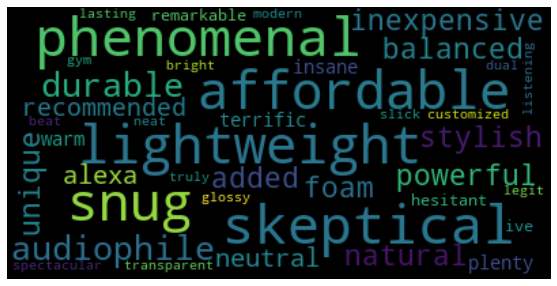

In [140]:
text = wordsDump[0:40]['words'].apply(lambda x: str(x)).values

text = ' '.join(text)
# txt = "The rain in Spain"
# x = re.search("^The.*Spain$", txt)

# import re
# for elem in text:
#     print(re.findall(r"\w[\w']+", elem))
    
    
from wordcloud import WordCloud

# Generate a word cloud image
# wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)


plt.figure(figsize=(20,5))

wordcloud.to_file(path.join(d, 'Top40Words.png'))

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

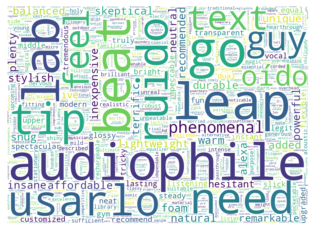

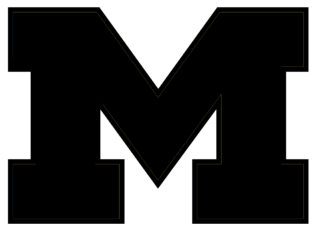

In [101]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from os import path

from wordcloud import WordCloud, STOPWORDS
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()


wordsDump = highAdjectivesRanking[~highAdjectivesRanking['words'].isin(intersection['words'].unique())].groupby('words').sum().sort_values(by='count',ascending=False).reset_index()
text = wordsDump['words'].apply(lambda x: str(x)).values

text = ' '.join(text)

# read the mask image
# taken from
# http://www.stencilry.org/stencils/movies/alice%20in%20wonderland/255fk.jpg
alice_mask = np.array(Image.open(path.join(d, '1200px-Michigan_Wolverines_logo.png')))

stopwords = set(STOPWORDS)
stopwords.add("said")

wc = WordCloud(background_color="white", max_words=2000, mask=alice_mask,
               stopwords=stopwords, contour_width=3, contour_color='steelblue')
# plt.figure(figsize=(20,5))



# generate word cloud
wc.generate(text)

# store to file
wc.to_file(path.join(d, 'wordcloud.png'))

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.imshow(alice_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()


In [102]:
# .merge(df2, left_on='lkey', right_on='rkey')

## Get top positive words for each product.

The words for each product are not to be unique. We will want to also include negative words. the DF should look like:<br><br>
    ProductName1, product name 2, product name 3

## Word pairs entire list of reviews

This will create a data frame of all the reviews. We want to see overall what are the different words between the purchased and not purchased sets?

In [103]:

def GetReviewPairsCounts(df):
    data = df.copy()
#     data["tempPairs"] = data[pairsColumn]
#     data = data[pairsColumn].apply(pd.Series)\
#     .merge(data, right_index = True, left_index = True) \
#     .drop(["tempPairs"], axis = 1)\
#     .drop([pairsColumn], axis = 1)\
#     .melt(id_vars =columnstoKeep, value_name = "pairs") \
#     .drop("variable", axis = 1).dropna()


    data['text_pairs_valid']=data['text_pairs'].apply(lambda x: True if len(x)>0 else False)
    data = data.where(data['text_pairs_valid'] == True).dropna().drop(columns=['text_pairs_valid'])

    data['text_pairs'] = data['text_pairs'].apply(lambda x: [tuple(elem) for elem in x ])
    data= data[['Manufacturer', 'ProductName', 'review_rating', 'verified_purchase',
       'review_date', 'review_title', 'review_text','text_pairs']]

    data = data.set_index(['Manufacturer', 'ProductName', 'review_rating', 'verified_purchase',
       'review_date', 'review_title', 'review_text']).apply(pd.Series.explode).reset_index()

    
    
    # count should be a ratio of the current elem/total sets. NOTE: can't really count them here...value too small.
    totalReview= len(df['verified_purchase'])
    
    
    #NOTE: WE HAVE TO DO THE RATIO FOR THE NUMBER OF REVIEWS THAT PRODUCT HAS?
    
    
    
#     data['count'] = data['verified_purchase'].apply(lambda x: 1/totalReview)
#     data['count'] = data['verified_purchase'].apply(lambda x: 1)
    
    # we can't group by a set, so we need to make it a string like object, so we can hash it.
#     data['pairs_hashable'] = data['pairs'].apply(lambda x: repr(x))
    
#     countsdf = data.pairs.value_counts().reset_index().rename(columns={'pairs':'total','index':'pairs'})
    
#     pd.merge(data,countsdf, on='pairs', )
    
    return data

def CreateFullDFOfProductsAndWordPairs(amzn_Df):
    ### this function will try to keep the product name field and format a dataframe that we can easily parse
    final_df = None
#     for elem in amzn_df['ProductName'].unique():
        
#         df = amzn_df.where(amzn_df['ProductName'] == elem).dropna()
#         df = df[['review_date','verified_purchase','text_pairs']]
#         df = GetReviewPairsCounts(df )
#         df['ProductName'] = df['pairs'].apply(lambda x: elem)
#         if final_df is None:
#             final_df=df
#         else:
#             final_df = pd.concat([final_df,df])
            
#     return final_df

    return GetReviewPairsCounts(amzn_Df )



In [104]:

# df = amzn_df.where(amzn_df['ProductName'] == 'AirPods Pro').dropna()
# df = df[['review_date','verified_purchase','text_pairs']]
# df = GetReviewPairsCounts(df, 'text_pairs',['review_date', 'verified_purchase'] )

# df_happy_explode = df_happy.set_index(['Country', 'Happiness Score', 'Standard Error', 'lower_95',
#                                        'upper_95', 'lower_66', 'upper_66'])\
#                             .apply(pd.Series.explode)\
#                             .reset_index()
# print(amzn_df.columns)
# df = amzn_df.copy()
# df['text_pairs'] = df['text_pairs'].apply(lambda x: [tuple(elem) for elem in x ])
# df= df[['Manufacturer', 'ProductName', 'review_rating', 'verified_purchase',
#        'review_date', 'review_title', 'review_text','text_pairs']]

# df.set_index(['Manufacturer', 'ProductName', 'review_rating', 'verified_purchase',
#        'review_date', 'review_title', 'review_text']).apply(pd.Series.explode).reset_index()
# import numpy as np
# import pandas as pd
# df.explode('text_pairs')
# df['text_pairs'].apply(pd.Series.explode)
# df.head()

# df[:1]['text_pairs'].apply(lambda x: [elem for elem in x])


In [105]:
pd.__version__

'1.0.3'

In [115]:

# amzn_df.head()


In [128]:
# data
fivestarsPairs_df = amzn_df.where(amzn_df['review_rating'] == 5).dropna()


# wordPairsAllReviews_df= CreateFullDFOfProductsAndWordPairs(fivestarsPairs_df)
# wordPairsAllReviews_df.head()

df =GetReviewPairsCounts(fivestarsPairs_df)
print(df.columns)
df['count']=df['text_pairs'].apply(lambda x: 1)

df = df.groupby(['ProductName','Manufacturer','text_pairs']).sum().reset_index().sort_values(by=['ProductName','count'], ascending=False)


def GetTopProductPairs(df):
    df = GetReviewPairsCounts(df)
    df['count']=df['text_pairs'].apply(lambda x: 1)
    
    highReviews = df.where(df['review_rating'] > 4).dropna()
    lowReviews = df.where(df['review_rating'] < 2).dropna()
    
    products = df['ProductName'].unique()
    
    temp = None
    for product in products:
        temp_df = df.where(df['ProductName'] == product).dropna()
        high = temp_df.where(temp_df['review_rating'] > 4).dropna()[['text_pairs','count']]
        low  = temp_df.where(temp_df['review_rating'] < 2).dropna()[['text_pairs','count']]
        
        intersection = high[['text_pairs']].merge(low, left_on='text_pairs', right_on='text_pairs', how='inner')
#         temp = high
        
        high['text_pairs'].isin(intersection['text_pairs'].unique())
        
        top_adj_words_df = high[~high['text_pairs'].isin(intersection['text_pairs'].unique())].groupby('text_pairs').sum().sort_values(by='count',ascending=False).reset_index()
        lower_adj_words_df = low[~low['text_pairs'].isin(intersection['text_pairs'].unique())].groupby('text_pairs').sum().sort_values(by='count',ascending=False).reset_index()
        top_adj_words_df = top_adj_words_df.rename(columns={'text_pairs':product+'_best'}).reset_index().drop(columns=['count'])
        lower_adj_words_df = lower_adj_words_df.rename(columns={'text_pairs':product+'_worst'}).reset_index().drop(columns=['count'])
        
        tdf = top_adj_words_df.merge(lower_adj_words_df, left_on='index', right_on='index', how='inner')
#         tdf= tds.drop(columns=['count'])
        if temp is None:
            temp=tdf
        else:
            temp= temp.merge(tdf, left_on='index', right_on='index', how='inner')
        
#         high = high[['text_pairs','count']].groupby(['text_pairs']).sum().reset_index().sort_values(by=['ProductName','count'], ascending=False)
    return temp

productWordPairs = GetTopProductPairs(amzn_df)[:20]

productBest = productWordPairs[['index', 'AirPods Pro_best','Elite 75t_best',
       'Free_best', 'Galaxy Buds Plus_best',
       'NC700_best',
       'Soundcore Liberty 2 Pro_best', 
       'Soundcore Liberty Air 2_best', 
       'Soundcore Life Q20_best', 
       'WF-1000XM3_best']]

productWorst = productWordPairs[['index', 'AirPods Pro_worst','Elite 75t_worst', 'Free_worst',
       'Galaxy Buds Plus_worst', 'NC700_worst',
       'Soundcore Liberty 2 Pro_worst','Soundcore Liberty Air 2_worst',
       'Soundcore Life Q20_worst', 'WF-1000XM3_worst']]

print(productWordPairs.columns)
productWordPairs

Index(['Manufacturer', 'ProductName', 'review_rating', 'verified_purchase',
       'review_date', 'review_title', 'review_text', 'text_pairs'],
      dtype='object')
Index(['index', 'AirPods Pro_best', 'AirPods Pro_worst', 'Elite 75t_best',
       'Elite 75t_worst', 'Free_best', 'Free_worst', 'Galaxy Buds Plus_best',
       'Galaxy Buds Plus_worst', 'NC700_best', 'NC700_worst',
       'Soundcore Liberty 2 Pro_best', 'Soundcore Liberty 2 Pro_worst',
       'Soundcore Liberty Air 2_best', 'Soundcore Liberty Air 2_worst',
       'Soundcore Life Q20_best', 'Soundcore Life Q20_worst',
       'WF-1000XM3_best', 'WF-1000XM3_worst'],
      dtype='object')


In [129]:
html = productBest.to_html()
print(html)
# We want ProductName, Manufacturer, pairs_hashable, sum
# highRatings = data.where(data['review_rating'] >= 4).dropna()
# lowRatings = data.where(data['review_rating'] <= 2).dropna()
# lowRatings
# lowRatings.groupby(['verified_purchase','ProductName','Manufacturer','pairs_hashable']).sum()

# data[['pairs_hashable','count']].groupby('pairs_hashable').sum()


# data[['pairs','count']].groupby('pairs').sum()

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>index</th>
      <th>AirPods Pro_best</th>
      <th>Elite 75t_best</th>
      <th>Free_best</th>
      <th>Galaxy Buds Plus_best</th>
      <th>NC700_best</th>
      <th>Soundcore Liberty 2 Pro_best</th>
      <th>Soundcore Liberty Air 2_best</th>
      <th>Soundcore Life Q20_best</th>
      <th>WF-1000XM3_best</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0</td>
      <td>(product, great)</td>
      <td>(truli, wireless)</td>
      <td>(so, far)</td>
      <td>(ambient, sound)</td>
      <td>(control, touch)</td>
      <td>(in, ear)</td>
      <td>(as, well)</td>
      <td>(as, good)</td>
      <td>(connect, app)</td>
    </tr>
    <tr>
      <th>1</th>
      <td>1</td>
      <td>(amaz, sound)</td>
      <td>(so, far)</td>
      <td>(usb, c)</td>
      <td>(call, qualiti)</td>
      <td>(veri, comfort)</td>
      <td>(ear, your)</td>
      <td>(charg,

In [130]:
html = productWorst.to_html()
print(html)

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>index</th>
      <th>AirPods Pro_worst</th>
      <th>Elite 75t_worst</th>
      <th>Free_worst</th>
      <th>Galaxy Buds Plus_worst</th>
      <th>NC700_worst</th>
      <th>Soundcore Liberty 2 Pro_worst</th>
      <th>Soundcore Liberty Air 2_worst</th>
      <th>Soundcore Life Q20_worst</th>
      <th>WF-1000XM3_worst</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0</td>
      <td>(work, doesn)</td>
      <td>(support, jabra)</td>
      <td>(in, cut)</td>
      <td>(left, side)</td>
      <td>(disappoint, veri)</td>
      <td>(left, bud)</td>
      <td>(connect, stay)</td>
      <td>(n, c)</td>
      <td>(softwar, connect)</td>
    </tr>
    <tr>
      <th>1</th>
      <td>1</td>
      <td>(disappoint, extrem)</td>
      <td>(would, earbud)</td>
      <td>(that, state)</td>
      <td>(money, back)</td>
      <td>(minut, 10)</td>
      <td>(stop, conne

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>index</th>
      <th>AirPods Pro_best</th>
      <th>Elite 75t_best</th>
      <th>Free_best</th>
      <th>Galaxy Buds Plus_best</th>
      <th>NC700_best</th>
      <th>Soundcore Liberty 2 Pro_best</th>
      <th>Soundcore Liberty Air 2_best</th>
      <th>Soundcore Life Q20_best</th>
      <th>WF-1000XM3_best</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0</td>
      <td>(product, great)</td>
      <td>(truli, wireless)</td>
      <td>(so, far)</td>
      <td>(ambient, sound)</td>
      <td>(control, touch)</td>
      <td>(in, ear)</td>
      <td>(as, well)</td>
      <td>(as, good)</td>
      <td>(connect, app)</td>
    </tr>
    <tr>
      <th>1</th>
      <td>1</td>
      <td>(amaz, sound)</td>
      <td>(so, far)</td>
      <td>(usb, c)</td>
      <td>(call, qualiti)</td>
      <td>(veri, comfort)</td>
      <td>(ear, your)</td>
      <td>(charg, wireless)</td>
      <td>(so, far)</td>
      <td>(as, far)</td>
    </tr>
    <tr>
      <th>2</th>
      <td>2</td>
      <td>(qualiti, great)</td>
      <td>(good, realli)</td>
      <td>(qualiti, great)</td>
      <td>(pro, airpod)</td>
      <td>(bose, sound)</td>
      <td>(earbud, wireless)</td>
      <td>(pro, airpod)</td>
      <td>(price, great)</td>
      <td>(that, headphon)</td>
    </tr>
    <tr>
      <th>3</th>
      <td>3</td>
      <td>(great, fit)</td>
      <td>(recommend, highli)</td>
      <td>(as, good)</td>
      <td>(so, far)</td>
      <td>(out, block)</td>
      <td>(amaz, sound)</td>
      <td>(recommend, highli)</td>
      <td>(last, batteri)</td>
      <td>(product, great)</td>
    </tr>
    <tr>
      <th>4</th>
      <td>4</td>
      <td>(love, he)</td>
      <td>(in, app)</td>
      <td>(good, realli)</td>
      <td>(earbud, wireless)</td>
      <td>(nois, level)</td>
      <td>(in, your)</td>
      <td>(product, great)</td>
      <td>(price, at)</td>
      <td>(best, earbud)</td>
    </tr>
    <tr>
      <th>5</th>
      <td>5</td>
      <td>(earbud, wireless)</td>
      <td>(qualiti, great)</td>
      <td>(recommend, highli)</td>
      <td>(qualiti, great)</td>
      <td>(veri, well)</td>
      <td>(veri, good)</td>
      <td>(good, realli)</td>
      <td>(bass, boost)</td>
      <td>(easi, use)</td>
    </tr>
    <tr>
      <th>6</th>
      <td>6</td>
      <td>(worth, well)</td>
      <td>(galaxi, bud)</td>
      <td>(product, great)</td>
      <td>(day, all)</td>
      <td>(veri, nice)</td>
      <td>(listen, music)</td>
      <td>(wireless, true)</td>
      <td>(nois, good)</td>
      <td>(galaxi, bud)</td>
    </tr>
    <tr>
      <th>7</th>
      <td>7</td>
      <td>(worth, definit)</td>
      <td>(high, mid)</td>
      <td>(free, earfun)</td>
      <td>(ear, your)</td>
      <td>(veri, happi)</td>
      <td>(case, charg)</td>
      <td>(better, sound)</td>
      <td>(product, great)</td>
      <td>(so, good)</td>
    </tr>
    <tr>
      <th>8</th>
      <td>8</td>
      <td>(like, realli)</td>
      <td>(through, featur)</td>
      <td>(last, batteri)</td>
      <td>(listen, music)</td>
      <td>(high, end)</td>
      <td>(best, sound)</td>
      <td>(control, touch)</td>
      <td>(set, headphon)</td>
      <td>(nois, level)</td>
    </tr>
    <tr>
      <th>9</th>
      <td>9</td>
      <td>(worth, everi)</td>
      <td>(secur, fit)</td>
      <td>(good, sound)</td>
      <td>(better, much)</td>
      <td>(clear, crystal)</td>
      <td>(phone, call)</td>
      <td>(first, pair)</td>
      <td>(valu, great)</td>
      <td>(how, much)</td>
    </tr>
    <tr>
      <th>10</th>
      <td>10</td>
      <td>(from, upgrad)</td>
      <td>(out, take)</td>
      <td>(price, great)</td>
      <td>(amaz, sound)</td>
      <td>(volum, control)</td>
      <td>(recommend, highli)</td>
      <td>(appl, airpod)</td>
      <td>(veri, nice)</td>
      <td>(sound, good)</td>
    </tr>
    <tr>
      <th>11</th>
      <td>11</td>
      <td>(amaz, qualiti)</td>
      <td>(while, listen)</td>
      <td>(ear, fit)</td>
      <td>(work, at)</td>
      <td>(high, qualiti)</td>
      <td>(in, stay)</td>
      <td>(headphon, wireless)</td>
      <td>(in, headphon)</td>
      <td>(qualiti, excel)</td>
    </tr>
    <tr>
      <th>12</th>
      <td>12</td>
      <td>(penni, everi)</td>
      <td>(ever, own)</td>
      <td>(amaz, sound)</td>
      <td>(nois, background)</td>
      <td>(comfort, fit)</td>
      <td>(veri, comfort)</td>
      <td>(price, at)</td>
      <td>(cancel, great)</td>
      <td>(so, sound)</td>
    </tr>
    <tr>
      <th>13</th>
      <td>13</td>
      <td>(out, nois)</td>
      <td>(5, hour)</td>
      <td>(easi, pair)</td>
      <td>(abl, be)</td>
      <td>(best, far)</td>
      <td>(would, be)</td>
      <td>(as, good)</td>
      <td>(out, nois)</td>
      <td>(ear, fit)</td>
    </tr>
    <tr>
      <th>14</th>
      <td>14</td>
      <td>(veri, nice)</td>
      <td>(featur, great)</td>
      <td>(work, at)</td>
      <td>(as, good)</td>
      <td>(cancel, amaz)</td>
      <td>(soundcor, liberti)</td>
      <td>(amaz, sound)</td>
      <td>(batteri, long)</td>
      <td>(volum, no)</td>
    </tr>
    <tr>
      <th>15</th>
      <td>15</td>
      <td>(get, use)</td>
      <td>(in, secur)</td>
      <td>(great, fit)</td>
      <td>(featur, sound)</td>
      <td>(from, expect)</td>
      <td>(so, far)</td>
      <td>(left, ear)</td>
      <td>(ear, headphon)</td>
      <td>(complaint, onli)</td>
    </tr>
    <tr>
      <th>16</th>
      <td>16</td>
      <td>(product, good)</td>
      <td>(awesom, sound)</td>
      <td>(easi, use)</td>
      <td>(that, bud)</td>
      <td>(talk, phone)</td>
      <td>(pro, airpod)</td>
      <td>(build, qualiti)</td>
      <td>(batteri, great)</td>
      <td>(cancel, as)</td>
    </tr>
    <tr>
      <th>17</th>
      <td>17</td>
      <td>(recommend, definit)</td>
      <td>(best, earbud)</td>
      <td>(time, long)</td>
      <td>(bud, wireless)</td>
      <td>(comfort, super)</td>
      <td>(high, mid)</td>
      <td>(ha, been)</td>
      <td>(rang, price)</td>
      <td>(how, well)</td>
    </tr>
    <tr>
      <th>18</th>
      <td>18</td>
      <td>(time, at)</td>
      <td>(love, that)</td>
      <td>(use, been)</td>
      <td>(in, stay)</td>
      <td>(out, filter)</td>
      <td>(set, eq)</td>
      <td>(issu, ani)</td>
      <td>(hour, 40)</td>
      <td>(in, place)</td>
    </tr>
    <tr>
      <th>19</th>
      <td>19</td>
      <td>(use, eas)</td>
      <td>(that, bud)</td>
      <td>(love, that)</td>
      <td>(in, case)</td>
      <td>(nois, best)</td>
      <td>(ear, tip)</td>
      <td>(usb, c)</td>
      <td>(more, much)</td>
      <td>(would, definit)</td>
    </tr>
  </tbody>
</table>

In [114]:
print(wordPairsAllReviews_df.columns)
# wordPairsAllReviews_df[['count', 'pairs_hashable','ProductName']].groupby(by=['ProductName','pairs_hashable']).sum().sort_values(by='count',ascending=False)

# have to drop the single values in the pairs...not sure why there's a single value.
wordPairsAllReviews_df['numPairs'] = wordPairsAllReviews_df['pairs'].apply(lambda x: len(x))
wordPairsAllReviews_df = wordPairsAllReviews_df.where(wordPairsAllReviews_df['numPairs'] > 1).dropna()
# wordPairsAllReviews_df['pairs_hashable']#.apply(lambda x: len(x))
# wordPairsAllReviews_df['pairs'].apply(lambda x: len(x))
wordPairsAllReviews_df[['count', 'pairs_hashable']].groupby(by=['pairs_hashable']).sum().sort_values(by='count',ascending=False)

Index(['review_date', 'verified_purchase', 'pairs', 'count', 'pairs_hashable',
       'ProductName', 'numPairs'],
      dtype='object')


,count
pairs_hashable,
"{'quality', 'sound'}",2.355383
"{'noise', 'cancelling'}",1.733864
"{'life', 'battery'}",1.723270
"{'cancellation', 'noise'}",1.252164
"{'great', 'sound'}",0.869760
...,...
"{'fantastic', 'ok'}",0.000242
"{'street', 'sounds'}",0.000242
"{'fantastic', 'modes'}",0.000242


In [109]:
overallPopularwords= wordPairsAllReviews_df.groupby(['pairs_hashable','verified_purchase']).sum().reset_index()


overallPopularwords_notPurchased = overallPopularwords.where(overallPopularwords['verified_purchase'] == 0).dropna()
overallPopularwords_notPurchased = overallPopularwords_notPurchased.sort_values(by=['count'],ascending =False).reset_index().drop(columns=['index'])

overallPopularwords_purchased = overallPopularwords.where(overallPopularwords['verified_purchase'] == 1).dropna()
overallPopularwords_purchased = overallPopularwords_purchased.sort_values(by=['count'],ascending =False).reset_index().drop(columns=['index'])

# now we have two datasets one with purchased the other not purchased.

In [110]:
overallPopularwords_notPurchased.head(10)

,pairs_hashable,verified_purchase,count,numPairs
0,"{'quality', 'sound'}",0.0,0.495996,1150.0
1,"{'noise', 'cancelling'}",0.0,0.466216,1228.0
2,"{'life', 'battery'}",0.0,0.362033,784.0
3,"{'cancellation', 'noise'}",0.0,0.309101,802.0
4,"{'as', 'well'}",0.0,0.172777,364.0
5,"{'great', 'sound'}",0.0,0.142890,298.0
6,"{'as', 'good'}",0.0,0.136030,308.0
7,"{'ear', 'buds'}",0.0,0.133262,286.0
8,"{'case', 'charging'}",0.0,0.131994,278.0
9,"{'call', 'quality'}",0.0,0.123919,244.0


In [111]:
overallPopularwords_purchased.head(10)

,pairs_hashable,verified_purchase,count,numPairs
0,"{'quality', 'sound'}",1.0,1.859387,5212.0
1,"{'life', 'battery'}",1.0,1.361237,3404.0
2,"{'noise', 'cancelling'}",1.0,1.267649,4106.0
3,"{'cancellation', 'noise'}",1.0,0.943063,3518.0
4,"{'great', 'sound'}",1.0,0.726869,1988.0
5,"{'ear', 'buds'}",1.0,0.490417,1206.0
6,"{'in', 'ear'}",1.0,0.458294,1404.0
7,"{'as', 'well'}",1.0,0.449028,1198.0
8,"{'very', 'good'}",1.0,0.410845,1198.0
9,"{'as', 'good'}",1.0,0.408481,1238.0


In [112]:
# now we need to merge the two verified _purchase lists into a data frame. We don't want pairs that appear in the other list.
# we can say from the top 20 words, which ones are unique?

# we can take the intersection between two lists then remove those words found in the intersection from those of both lists. 

In [113]:
mostPopularWordPairs = data.groupby(['pairs_hashable','verified_purchase']).sum().reset_index()
mostPopularWordPairsPurchased = mostPopularWordPairs.where(mostPopularWordPairs['verified_purchase'] == 1).dropna()
mostPopularWordPairsPurchased.sort_values(by=['count'],ascending =False).reset_index().drop(columns=['index'])

NameError: name 'data' is not defined